### 从零开始搭建神经网络

之前我们用RNN模型对时间序列数据做预测，直接用到了深度神经网络的模型结构。下面的实验将从零开始搭建神经网络，逐步增加模型的复杂度，比较模型在个股波动率预测上的效果。

### 数据预处理

之前的实验里，我们都用了沪深300指数作为样本数据，这次实验我们选用个股科大讯飞（002230.SZ）。第一步还是导入相关的库。

In [1]:
import akshare as ak
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Flatten, Dropout
from tensorflow import keras
from pylab import plt, mpl

这里股票的历史行情，我们使用前复权后的结果，我们先看下收盘价对应的走势图。

In [2]:
ticker = 'sz002230'
sz002230_daily = ak.stock_zh_a_daily(symbol=ticker, start_date="20100101", end_date="20250101", adjust="qfq")
sz002230_close = sz002230_daily.close
sz002230_date = sz002230_daily.date
sz002230_close.shape

(2910,)

之前的实验已经看到，RNN在预测波动率的效果较好，所以接下来用同样的思路对个股的波动率做预测。

In [3]:
sz002230_chg = sz002230_close/sz002230_close.shift(1)-1
sz002230_chg.dropna(inplace = True)
sz002230_realized_vol = sz002230_chg.rolling(5).std()
sz002230_realized_vol.dropna(inplace = True)
sz002230_realized_vol.shape

(2905,)

In [4]:
sz002230_close[5 :].shape

(2905,)

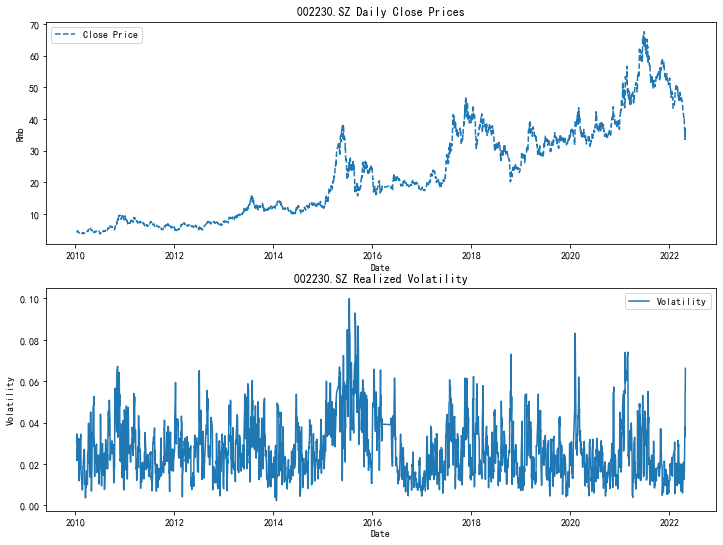

In [5]:
fig, ax=plt.subplots(2, 1, figsize=(12,9))
ax[0].plot(sz002230_date[5:], sz002230_close[5:], label='Close Price', linestyle='--')
ax[0].set_title('002230.SZ Daily Close Prices')
ax[0].set(xlabel='Date', ylabel='Rmb')
ax[0].legend(loc='best')
ax[1].plot(sz002230_date[5:], sz002230_realized_vol, linestyle='solid', label="Volatility")
ax[1].set_title('002230.SZ Realized Volatility')
ax[1].set(xlabel='Date', ylabel='Volatility')
ax[1].legend(loc='best')

根据之前实验结果，我们将原始数据先做标准化处理、同时要把index重设下。

In [6]:
sz002230_realized_vol =  sz002230_realized_vol.reset_index(drop=True)
sz002230_realized_vol = (sz002230_realized_vol-sz002230_realized_vol.mean())/sz002230_realized_vol.std()

In [7]:
def split_sequence(sequence,n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

这里需要注意，我们将输入变量x转变为了三维数据结构【batch size, lags, dimensionality】，这里dimensionality = 1代表我们处理的是时间序列是单变量时间序列，即：univariate time series。换言之，每个时间点t，只对应1个值。

In [8]:
lags = 5
dimensionality = 1

In [9]:
x_sz002230, y_sz002230 = split_sequence(sz002230_realized_vol, lags)

In [10]:
x_sz002230 = x_sz002230.reshape((x_sz002230.shape[0], x_sz002230.shape[1], dimensionality))
y_sz002230 = y_sz002230.reshape(len(y_sz002230),-1)

In [11]:
x_sz002230.shape

(2900, 5, 1)

In [12]:
y_sz002230.shape

(2900, 1)

In [13]:
x_sz002230[0]

array([[ 2.57748396e-01],
       [ 2.38314137e-01],
       [ 5.36730448e-01],
       [-3.74976880e-01],
       [-5.05493223e-04]])

In [14]:
y_sz002230[0]

array([-0.2557382])

In [15]:
sz002230_realized_vol[:6]

0    0.257748
1    0.238314
2    0.536730
3   -0.374977
4   -0.000505
5   -0.255738
Name: close, dtype: float64

从上面第一个batch显示的结果看，我们对时间序列数据的重构是成功的。接着将所有的数据分成training, validation, testing三个子集。

In [16]:
split1 = int((x_sz002230.shape[0])*0.80)
split2 = int((x_sz002230.shape[0])*0.90)
x_train, y_train = x_sz002230[:split1,:lags], y_sz002230[:split1,-1]
x_valid, y_valid = x_sz002230[split1:split2,:lags], y_sz002230[split1:split2,-1]
x_test, y_test = x_sz002230[split2:,:lags], y_sz002230[split2:,-1]

In [17]:
y_train = y_train.reshape(len(y_train),-1)
y_valid = y_valid.reshape(len(y_valid),-1)
y_test = y_test.reshape(len(y_test),-1)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(2320, 5, 1)
(2320, 1)
(290, 5, 1)
(290, 1)
(290, 5, 1)
(290, 1)


### 基准值

数据预处理完成后，我们可以先指定一个基准值。设定基准值的好处，是回答<u>“猴子都能选股”</u>的问题。别小看“猴子”的能力，我们训练的模型是否能超过盲选的结果？在时间序列预测里，我们用最近一个值代替预测值，就是我们用第5天的值，作为第6值的预测值。

In [19]:
y_pred = x_test[:, -1]
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.24201168310478482

上面的预测给出了我们错误率（Mean Squared Error）大概是0.24的结果。还可以用线性回归模型做类似的基准测试，模型给我们返回了MSE大约是0.25，比盲猜效果还差点。

In [20]:
model = Sequential()
model.add(Flatten(input_shape=[lags, 1]))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 2.88 s
Wall time: 2.26 s


In [23]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.24961153

### Simple RNN模型

接着我们还是搭建RNN模型，从最简单的开始。

In [24]:
model = Sequential()
model.add(SimpleRNN(1, input_shape=[None, 1]))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 3.66 s
Wall time: 2.97 s


In [28]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.43004474

结果看比盲猜效果还差，Simple RNN对上面的数据基本无效。

### Deep RNN模型

In [29]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(20))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 8.59 s
Wall time: 3.96 s


In [32]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.20486255

深度RNN的预测结果终于比基准值好些了，接着，我们继续增加神经元的数量。

In [45]:
model = Sequential()
model.add(SimpleRNN(256, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, None, 256)         66048     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115,457
Trainable params: 115,457
Non-trainable params: 0
_________________________________________________________________


In [47]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 21 s
Wall time: 5.69 s


In [48]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.2090508

从上面结果看，增加模型的复杂度并没有带来效果提升。

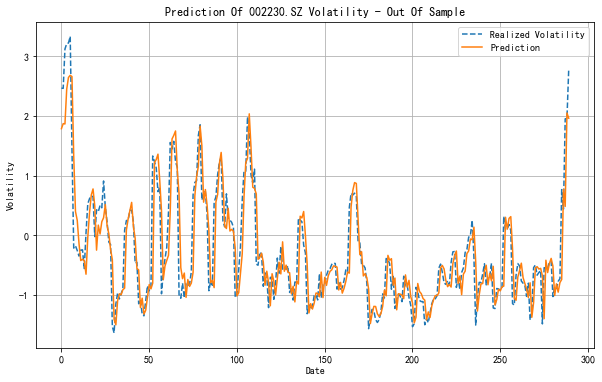

In [49]:
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(y_test, label='Realized Volatility', linestyle='--')
ax.plot(y_pred, linestyle='solid', label="Prediction")
ax.set_title('Prediction Of 002230.SZ Volatility - Out Of Sample')
ax.set(xlabel='Date', ylabel='Volatility')
ax.legend(loc='best')
plt.grid()